In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import defaultdict

In [17]:
class GameEnvironment:
    def __init__(self, size=5, max_energy=10, max_fatigue=10):
        self.size = size
        self.max_energy = max_energy
        self.max_fatigue = max_fatigue
        self.reset()
        
    def reset(self):
        # Define the map layout
        self.board = np.full((self.size, self.size), ' ')
        self.place_features()
        
        self.peter_pos = (0, 0)
        self.energy = self.max_energy
        self.fatigue = 0
        self.done = False
        return self.get_state()

    def place_features(self):
        # Place features like Apples (A), Trees (T), Grass (G), Wolf (W)
        self.apples = [(1, 2), (3, 3)]
        self.rest_tiles = [(0, 3), (2, 2), (4, 1)]
        self.wolf_pos = (4, 4)

        for x, y in self.apples:
            self.board[x, y] = 'A'
        for x, y in self.rest_tiles:
            self.board[x, y] = 'G'
        wx, wy = self.wolf_pos
        self.board[wx, wy] = 'W'

    def get_state(self):
        x, y = self.peter_pos
        return (x, y, self.energy, self.fatigue)

    def valid_actions(self):
        return ['UP', 'DOWN', 'LEFT', 'RIGHT']

    def move(self, action):
        if self.done:
            return self.get_state(), 0, True

        x, y = self.peter_pos
        if action == 'UP': x = max(0, x - 1)
        elif action == 'DOWN': x = min(self.size - 1, x + 1)
        elif action == 'LEFT': y = max(0, y - 1)
        elif action == 'RIGHT': y = min(self.size - 1, y + 1)

        self.peter_pos = (x, y)

        # Energy & Fatigue adjustments
        self.energy = max(0, self.energy - 1)
        self.fatigue = min(self.max_fatigue, self.fatigue + 1)

        tile = self.board[x, y]
        reward = -1  # step penalty

        if tile == 'A':
            self.energy = min(self.max_energy, self.energy + 5)
            reward += 5
        elif tile in ['G']:
            self.fatigue = max(0, self.fatigue - 3)
            reward += 2
        elif tile == 'W':
            self.done = True
            if self.energy >= 5 and self.fatigue <= 5:
                reward = 100  # victory
            else:
                reward = -100  # defeat

        # End game if exhausted
        if self.energy <= 0:
            self.done = True
            reward = -50

        return self.get_state(), reward, self.done

In [19]:
class QLearningAgent:
    def __init__(self, actions, alpha=0.1, gamma=0.95, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01):
        self.q_table = defaultdict(lambda: defaultdict(float))
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.actions = actions

    def choose_action(self, state):
        if random.random() < self.epsilon:
            return random.choice(self.actions)
        qs = self.q_table[state]
        return max(qs, key=qs.get) if qs else random.choice(self.actions)

    def learn(self, state, action, reward, next_state):
        max_future_q = max(self.q_table[next_state].values()) if self.q_table[next_state] else 0
        current_q = self.q_table[state][action]
        self.q_table[state][action] += self.alpha * (reward + self.gamma * max_future_q - current_q)

    def decay_epsilon(self):
        self.epsilon = max(self.min_epsilon, self.epsilon * self.epsilon_decay)

In [21]:
env = GameEnvironment()
agent = QLearningAgent(actions=env.valid_actions())

episodes = 5000
win_count = 0
loss_count = 0
rewards = []

for ep in range(episodes):
    state = env.reset()
    total_reward = 0

    for _ in range(50):  # Max steps per episode
        action = agent.choose_action(state)
        next_state, reward, done = env.move(action)
        agent.learn(state, action, reward, next_state)
        state = next_state
        total_reward += reward
        if done:
            if reward == 100:
                win_count += 1
            else:
                loss_count += 1
            break
    agent.decay_epsilon()
    rewards.append(total_reward)

print(f"Q-Learning Wins: {win_count}, Losses: {loss_count}")

Q-Learning Wins: 4521, Losses: 380


In [23]:
def random_walk_simulation(episodes=5000):
    wins = 0
    losses = 0

    for _ in range(episodes):
        env = GameEnvironment()
        state = env.reset()

        for _ in range(50):
            action = random.choice(env.valid_actions())
            next_state, reward, done = env.move(action)
            state = next_state
            if done:
                if reward == 100:
                    wins += 1
                else:
                    losses += 1
                break
    return wins, losses

rw_wins, rw_losses = random_walk_simulation()
print(f"Random Walk Wins: {rw_wins}, Losses: {rw_losses}")

Random Walk Wins: 6, Losses: 4993


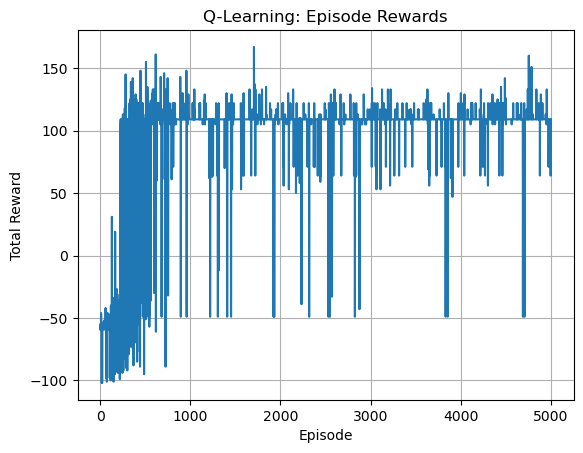

In [25]:
plt.plot(rewards)
plt.title("Q-Learning: Episode Rewards")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.grid()
plt.show()